In [15]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.losses import MeanSquaredError
from keras.optimizers import Adam

In [3]:
DATA_PATH = 'data_cars/'
all_files = os.listdir(DATA_PATH)

In [10]:
all_dataframes = []
for index, file in enumerate(all_files):
    print(f"Reading file: {file}")
    file_name = file.split('.')[0]
    df = pd.read_csv(DATA_PATH + file, sep=';')

    df['date'] = pd.to_datetime(df[file_name], format='%Y-%m-%d %H:%M')
    df = df.drop(columns=[file_name])

    df = df.set_index('date')
    df.columns = [f"{file_name}_{col}" for col in df.columns if col != 'date']
    all_dataframes.append(df)
    print(f"Finished reading file: {file}, shape = {df.shape}")

combined_df = pd.concat(all_dataframes, axis=1)
combined_df.fillna(method='ffill', inplace=True)
combined_df['hour'] = combined_df.index.hour
combined_df['day_of_week'] = combined_df.index.dayofweek

data = np.array(combined_df, dtype=float)
scaler = MinMaxScaler(feature_range=(0, 1))
#Don't transform the time labels -> this way the scaler also works inversely on prediction data because shapes are different otherwise
data = np.append(scaler.fit_transform(data[:, :-2]), data[:, -2:], axis=1)

Reading file: K711.csv
Finished reading file: K711.csv, shape = (2880, 31)
Reading file: K701.csv
Finished reading file: K701.csv, shape = (2880, 7)
Reading file: K703.csv
Finished reading file: K703.csv, shape = (2880, 10)
Reading file: K702.csv
Finished reading file: K702.csv, shape = (2880, 8)
Reading file: K406.csv
Finished reading file: K406.csv, shape = (2880, 8)
Reading file: K405.csv
Finished reading file: K405.csv, shape = (2880, 19)
Reading file: K159.csv
Finished reading file: K159.csv, shape = (2880, 11)
Reading file: K140.csv
Finished reading file: K140.csv, shape = (2880, 5)
Reading file: K134.csv
Finished reading file: K134.csv, shape = (2880, 7)
Reading file: K120.csv
Finished reading file: K120.csv, shape = (2880, 7)
Reading file: K709.csv
Finished reading file: K709.csv, shape = (2880, 17)


In [5]:
dataset = combined_df.to_numpy()

In [11]:
def splitSequence(seq, n_steps):

    #Declare X and y as empty list
    X = []
    y = []

    for i in range(len(seq)):
        #get the last index
        lastIndex = i + n_steps

        #if lastIndex is greater than length of sequence then break
        if lastIndex > len(seq) - 1:
            break

        # Create input and output sequence
        # Last 2 columns are time of day and day of week
        seq_X, seq_y = seq[i:lastIndex], seq[lastIndex, :-2]

        #append seq_X, seq_y in X and y list
        X.append(seq_X)
        y.append(seq_y)
        #Convert X and y into numpy array
    X = np.array(X)
    y = np.array(y)

    return X,y

In [12]:
num_of_steps = data.shape[0]
train_size = 0.7
val_size = 0.1

num_train = int(num_of_steps * train_size)
num_val = int(num_of_steps * val_size)

train_set = data[:num_train]
val_set = data[num_train:num_train + num_val]
test_set = data[num_train + num_val:]

print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(2015, 132)
(288, 132)
(577, 132)


In [13]:
input_sequence_length = 24
x_train, y_train = splitSequence(train_set, input_sequence_length)
x_val, y_val = splitSequence(val_set, input_sequence_length)
x_test, y_test = splitSequence(test_set, input_sequence_length)
x_train.shape, y_train.shape

((1991, 24, 132), (1991, 130))

In [23]:

#Add params to do optimizing at the top
input_dim = data.shape[1]
units = 128
output_size = y_train.shape[1]

input = keras.Input((input_sequence_length, input_dim))
#return sequences is necessary for sequential LSTM layers
lstm1 = LSTM(units, return_sequences=True)(input)
lstm2 = LSTM(units)(lstm1)
out = Dense(output_size)(lstm2)
model = keras.models.Model(inputs=input, outputs=out)
model.summary()

model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.001),
    metrics=[keras.metrics.RootMeanSquaredError()],
)

model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    #makes the training stop early if it notices no improvements on the validation set 10 times in a row, to prevent overfitting
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

# make predictions
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print(f'Train Score: {trainScore:.2f} RMSE')
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print(f'Test Score: {testScore:.2f} RMSE')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 24, 132)]         0         
                                                                 
 lstm_10 (LSTM)              (None, 24, 128)           133632    
                                                                 
 lstm_11 (LSTM)              (None, 128)               131584    
                                                                 
 dense_5 (Dense)             (None, 130)               16770     
                                                                 
Total params: 281,986
Trainable params: 281,986
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
63/63 [==============================] - 4s 32ms/step - loss: 0.0206 - root_mean_squared_error: 0.1435 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779
Epoch 2/5
63/63

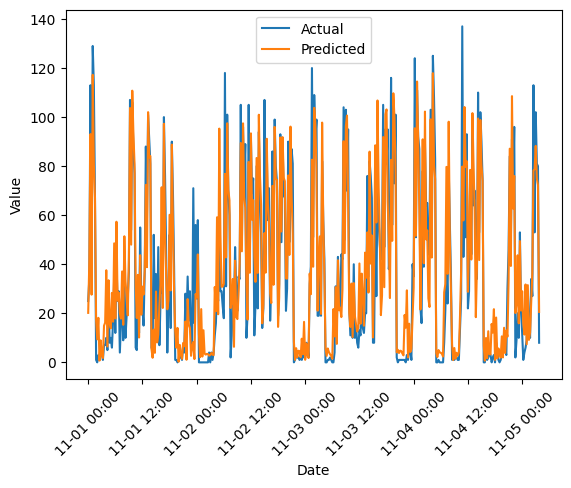

In [ ]:

import matplotlib.dates as mdates

num_results = 400
timestamps_to_plot = timestamps[:num_results]

fig, ax = plt.subplots()
ax.plot(timestamps_to_plot, inversed_y_test[:num_results], label='Actual')
ax.plot(timestamps_to_plot, inversed_predictions[:num_results], label='Predicted')

# Format the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()